In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from scipy.stats import norm 
from types import SimpleNamespace

import generating_functions as GeneratingFunctions
import generative_models as GenerativeModels
import noise as Noise 

mpl.style.use("seaborn-deep")

In [2]:
class StaticLinearEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def generate(self, x_star: float):
        noise               = Noise.zero_centered_normal(scale=self.params.y_star_std)
        generating_function = GeneratingFunctions.linear(
            x_star=x_star, 
            intercept=self.params.beta_0_star, 
            slope=self.params.beta_1_star) 
        
        return generating_function + noise

In [3]:
class ExactLinearAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        # Model components
        self.likelihood = None
        self.prior = None
        self.gen_model = None
        self.evidence = None
        self.posterior = None
        
    def generative_model(self, y: float, generating_function: callable):
        self.likelihood = norm.pdf(y, loc=generating_function, scale=self.params.std_y)
        self.prior      = norm.pdf(self.params.x_range, loc=self.params.m_x, scale=self.params.s_x)
        return self.likelihood * self.prior
        
    def infer_state(self, y: float):
        
        generating_function = GeneratingFunctions.linear(
            x_star=self.params.x_range, 
            intercept=self.params.beta_0, 
            slope=self.params.beta_1) 
    
        self.gen_model = self.generative_model(y, generating_function)
        self.evidence = np.sum(self.gen_model, axis=0)
        self.posterior = self.gen_model / self.evidence
        

In [4]:
def create_environment(name: str, params: dict):
    if name == "linear_regression":
        raise KeyError("Linear regression not yet supported")
    elif name == "static_linear":
        return StaticLinearEnvironment(params=params)
    else:
        raise KeyError(f"{name} not supported. Available models: TODO")
    
def create_agent(name: str, params: dict):
    if name == "exact_linear":
        return ExactLinearAgent(params=params)
    else:
        raise KeyError(f"{name} not supported. Available models: TODO")

In [13]:
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : float(1./100)   # Standard deviation of sensory data
}

# Agent parameters
agent_params = {
    "beta_0" : 3,    # Linear parameter intercept
    "beta_1" : 2,    # Linear parameter slope
    "std_y"  : 0.5,  # Likelihood standard deviation
    "m_x"   : 4,     # Prior mean
    "s_x"  : 0.5,    # Prior standard deviation
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

In [14]:
# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)
agent = create_agent(name="exact_linear", params=agent_params)

# Generate data
x_range = np.linspace(start=0.01, stop=5, num=500)
x_star = 2
y = env.generate(x_star)

# Perception: Agent infers belief over hidden state using sensory data
agent.infer_state(y)

<Figure size 432x288 with 0 Axes>

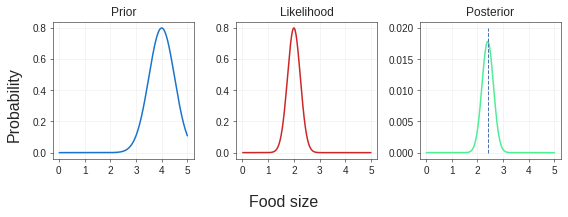

In [15]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Get likelihood and prior from agent
likelihood = agent.likelihood
prior = agent.prior
posterior = agent.posterior

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].vlines(x=(np.argmax(posterior) + 1) / 100, ymin=0, ymax=0.020, linestyles="dashed", linewidth=1)
# axes[2].set_ylim([-0.001, 0.02])

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [16]:
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7 under prior assumptions.')

The posterior mode is 2.4. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7 under prior assumptions.
